**While using the Moirai model, I faced some library conflicts in Google Colab. To prevent errors, I used a separate notebook for Moirai. Because TimeGPT and Moirai conflicted when used together, only Moirai results are shown here.**

In [1]:
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35


In [2]:
!pip uninstall -y torchvision torchaudio

Found existing installation: torchvision 0.19.1+cpu
Uninstalling torchvision-0.19.1+cpu:
  Successfully uninstalled torchvision-0.19.1+cpu


In [3]:
!pip -q install gluonts==0.14.4 utilsforecast
!pip -q install git+https://github.com/SalesforceAIResearch/uni2ts.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install torch==2.4.1 torchvision==0.19.1 --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.19.1%2Bcpu-cp312-cp312-linux_x86_64.whl (1.6 MB)


In [5]:
import pandas as pd
df = pd.read_csv("/content/electricity_short.csv", parse_dates=["ds"])
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,NP,2018-10-15 00:00:00,2.17,34078.0,1791.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NP,2018-10-15 01:00:00,4.03,33469.0,1489.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NP,2018-10-15 02:00:00,4.88,33313.0,1233.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NP,2018-10-15 03:00:00,10.47,33535.0,1035.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NP,2018-10-15 04:00:00,17.51,34267.0,854.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
future_ex_vars_df = pd.read_csv(
    "/content/electricity_future_vars.csv",
    parse_dates=["ds"]
)
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,NP,2018-12-24 00:00:00,49119.0,461.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NP,2018-12-24 01:00:00,48115.0,484.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NP,2018-12-24 02:00:00,47727.0,497.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NP,2018-12-24 03:00:00,47673.0,509.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NP,2018-12-24 04:00:00,47848.0,510.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from gluonts.dataset.pandas import PandasDataset

full_df = pd.concat([df, future_ex_vars_df], axis=0)
full_df = full_df.set_index("ds")

ds = PandasDataset.from_long_dataframe(
    full_df,
    target="y",
    item_id="unique_id",
    feat_dynamic_real=[
        "Exogenous1",
        "Exogenous2",
        "day_0",
        "day_1",
        "day_2",
        "day_3",
        "day_4",
        "day_5",
        "day_6",
    ],
)

In [8]:
from gluonts.dataset.split import split

train, test_template = split(ds, offset=-24)

test_data = test_template.generate_instances(
    prediction_length=24,
    windows=1,
    distance=24,
)

In [9]:
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(
        "Salesforce/moirai-1.0-R-large"
    ),
    prediction_length=24,
    context_length=240,
    patch_size="auto",
    num_samples=50,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

In [11]:
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(test_data.input)
forecasts = list(forecasts)

In [13]:
import numpy as np
moirai_preds = np.median(forecasts[0].samples, axis=0)

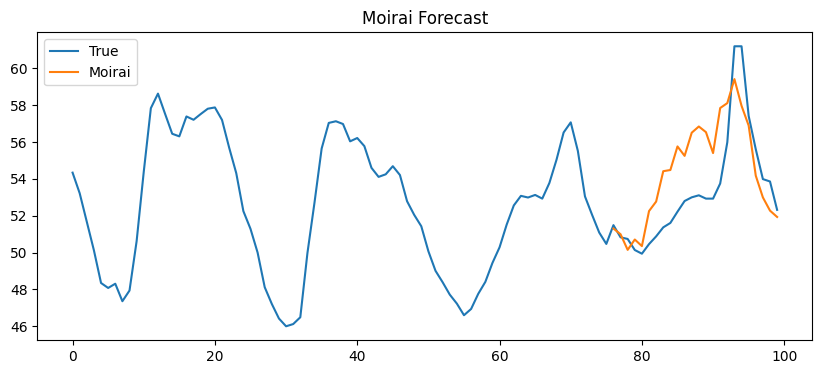

In [16]:
import matplotlib.pyplot as plt

prediction_length = 24

plt.figure(figsize=(10, 4))

y_true = df[df["unique_id"] == df["unique_id"].iloc[0]]["y"].values[-100:]

plt.plot(y_true, label="True")

# Moirai forecasts
plt.plot(
    range(len(y_true) - prediction_length, len(y_true)),
    moirai_preds,
    label="Moirai"
)

plt.legend()
plt.title("Moirai Forecast")
plt.show()

The graph shows the Moirai forecast (red) and the true values (blue) for the last 24 time steps. Moirai captures the main trend, while smoothing short-term fluctuations due to the zero-shot setting.